In [1]:
import backtrader as bt
import matplotlib.pyplot as plt
%matplotlib inline

import sqlalchemy as sa
from datetime import datetime as dt
from datetime import timedelta
import yfinance as yf
import itertools as it
import pandas as pd

from python.common.common import read_latest_file, read_pickle
from python.config_reader import ConfigReader
from python.common.mysql_connector import MySqlConnector
from schema.data_model import StockPrices, Symbols

In [275]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [130]:
# Initialise database connection
engine = MySqlConnector(
    host='localhost',
    user='root',
    password='db_user',
    database='stock_db'
)

con = engine.con

shortlist_stock_stmt = sa.select(Symbols.symbol) \
.where(Symbols.country=='United States') \
.where(Symbols.sector=='Technology')\
.order_by(Symbols.market_cap.desc())\
.limit(40)

shortlist_stock = con.execute(shortlist_stock_stmt).fetchall()

sql_df = pd.read_sql(
    sa.select(
        StockPrices.stock_datetime, StockPrices.symbol, StockPrices.open, StockPrices.high, StockPrices.low,
              StockPrices.close, StockPrices.adj_close, StockPrices.volume) \
    .where(StockPrices.symbol.in_([i[0] for i in shortlist_stock])), con)


In [272]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
timesteps = 60 # n of days to train per datapoint
predict_gap = 1 # Predict x days in advanced
symbol_list = sql_df['symbol'].unique()

X_train_list = []
y_train_list = []

# Iterate each stock and create steps individually
for symbol in symbol_list:
    X_train = []
    y_train = []
    
    # Creating a data structure with time-steps and 1 output
    stock_price_data = sql_df[sql_df['symbol'] == symbol]['close'].values
    scaled_data = sc.fit_transform(stock_price_data.reshape(-1,1))
    
    for i in range(timesteps + predict_gap, stock_price_data.shape[0]):
        X_train.append(scaled_data[i - timesteps - predict_gap:i - predict_gap, 0])
        y_train.append(scaled_data[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    X_train_list.append(X_train)
    y_train_list.append(y_train)

combined_X_train = np.concatenate(X_train_list)
combined_y_train = np.concatenate(y_train_list)

In [288]:
combined_X_train.shape

(23087, 60, 1)

In [289]:
combined_y_train.shape

(23087,)

In [184]:
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (combined_X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(combined_X_train, combined_y_train, epochs = 100, batch_size = 32)

Epoch 1/100
722/722 [==============================] - 50s 64ms/step - loss: 0.0043
Epoch 2/100
722/722 [==============================] - 44s 61ms/step - loss: 0.0019
Epoch 3/100
722/722 [==============================] - 45s 63ms/step - loss: 0.0016
Epoch 4/100
722/722 [==============================] - 43s 60ms/step - loss: 0.0014
Epoch 5/100
722/722 [==============================] - 45s 63ms/step - loss: 0.0012
Epoch 6/100
722/722 [==============================] - 46s 63ms/step - loss: 0.0012
Epoch 7/100
722/722 [==============================] - 43s 60ms/step - loss: 0.0010
Epoch 8/100
722/722 [==============================] - 43s 60ms/step - loss: 0.0010
Epoch 9/100
722/722 [==============================] - 43s 59ms/step - loss: 9.6137e-04
Epoch 10/100
722/722 [==============================] - 45s 63ms/step - loss: 9.6796e-04
Epoch 11/100
722/722 [==============================] - 43s 60ms/step - loss: 9.5804e-04
Epoch 12/100
722/722 [==============================] - 45s 62

In [274]:
# Saving model
model.save('./lstm_models/model_2')

INFO:tensorflow:Assets written to: ./lstm_model/model_2\assets


INFO:tensorflow:Assets written to: ./lstm_model/model_2\assets


In [191]:
# Saving model
#model.save('./lstm_model')

INFO:tensorflow:Assets written to: ./lstm_model\assets


INFO:tensorflow:Assets written to: ./lstm_model\assets


In [104]:
# model = Sequential()

# #Adding the first LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# # Adding a second LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 100))
# model.add(Dropout(0.4))

# # Adding the output layer
# model.add(Dense(units = 1))

# # Compiling the RNN
# model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# # Fitting the RNN to the Training set
# model.fit(X_train, y_train, epochs = 100, batch_size = 32)

# Validation

In [265]:
test_sql_df = pd.read_sql(
    sa.select(
        StockPrices.stock_datetime, StockPrices.symbol, StockPrices.open, StockPrices.high, StockPrices.low,
              StockPrices.close, StockPrices.adj_close, StockPrices.volume) \
    .where(StockPrices.symbol=='TSLA'), con)

test_data = test_sql_df['close'].values

In [266]:
# Test Validation
testing_set_scaled = sc.fit_transform(test_data.reshape(-1,1))
X_test = []
for i in range(timesteps + predict_gap, testing_set_scaled.shape[0]):
    X_test.append(testing_set_scaled[i - timesteps - predict_gap: i - predict_gap, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [267]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

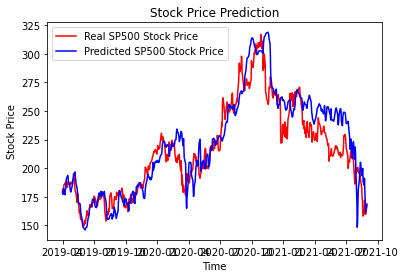

In [248]:
# Visualising the results
plt.plot(test_sql_df[timesteps + predict_gap:]['stock_datetime'], test_data[predict_gap + timesteps:], color = 'red', label = 'Real SP500 Stock Price')
plt.plot(test_sql_df[timesteps + predict_gap:]['stock_datetime'], predicted_stock_price, color = 'blue', label = 'Predicted SP500 Stock Price')
# plt.xticks(np.arange(0,459,50))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

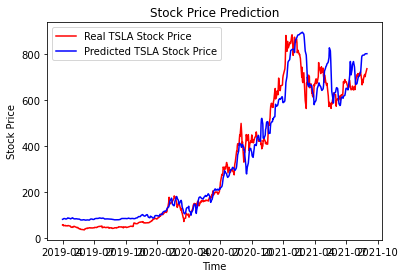

In [219]:
# Visualising the results
plt.plot(test_sql_df[timesteps + predict_gap:]['stock_datetime'], test_data[predict_gap + timesteps:], color = 'red', label = 'Real TSLA Stock Price')
plt.plot(test_sql_df[timesteps + predict_gap:]['stock_datetime'], predicted_stock_price, color = 'blue', label = 'Predicted TSLA Stock Price')
# plt.xticks(np.arange(0,459,50))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

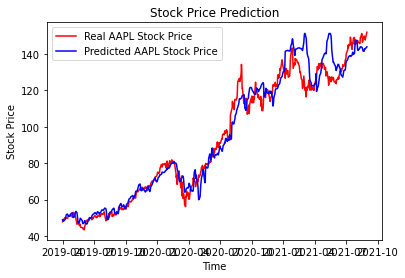

In [226]:
# Visualising the results
plt.plot(test_sql_df[timesteps + predict_gap:]['stock_datetime'], test_data[predict_gap + timesteps:], color = 'red', label = 'Real AAPL Stock Price')
plt.plot(test_sql_df[timesteps + predict_gap:]['stock_datetime'], predicted_stock_price, color = 'blue', label = 'Predicted AAPL Stock Price')
# plt.xticks(np.arange(0,459,50))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

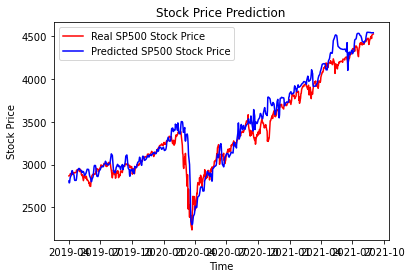

In [233]:
# Visualising the results
plt.plot(test_sql_df[timesteps + predict_gap:]['stock_datetime'], test_data[predict_gap + timesteps:], color = 'red', label = 'Real Dow Jones Stock Price')
plt.plot(test_sql_df[timesteps + predict_gap:]['stock_datetime'], predicted_stock_price, color = 'blue', label = 'Predicted Dow Jones Stock Price')
# plt.xticks(np.arange(0,459,50))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

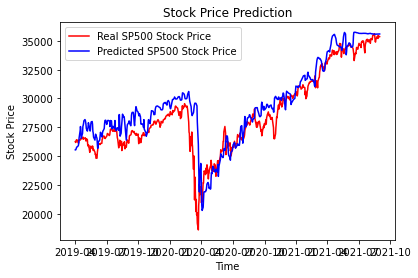

In [240]:
# Visualising the results
plt.plot(test_sql_df[timesteps + predict_gap:]['stock_datetime'], test_data[predict_gap + timesteps:], color = 'red', label = 'Real SP500 Stock Price')
plt.plot(test_sql_df[timesteps + predict_gap:]['stock_datetime'], predicted_stock_price, color = 'blue', label = 'Predicted SP500 Stock Price')
# plt.xticks(np.arange(0,459,50))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

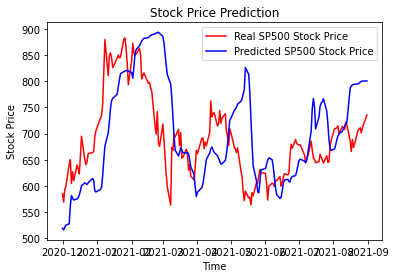

In [268]:
# Visualising the results
plt.plot(test_sql_df[timesteps + predict_gap:]['stock_datetime'][422:], test_data[predict_gap + timesteps:][422:], color = 'red', label = 'Real SP500 Stock Price')
plt.plot(test_sql_df[timesteps + predict_gap:]['stock_datetime'][422:], predicted_stock_price[422:], color = 'blue', label = 'Predicted SP500 Stock Price')
# plt.xticks(np.arange(0,459,50))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

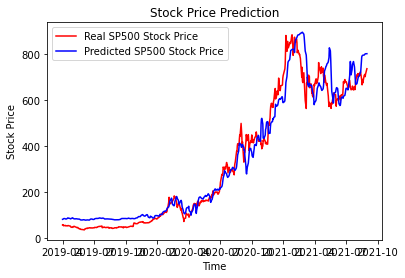

In [269]:
# Visualising the results
plt.plot(test_sql_df[timesteps + predict_gap:]['stock_datetime'], test_data[predict_gap + timesteps:], color = 'red', label = 'Real SP500 Stock Price')
plt.plot(test_sql_df[timesteps + predict_gap:]['stock_datetime'], predicted_stock_price, color = 'blue', label = 'Predicted SP500 Stock Price')
# plt.xticks(np.arange(0,459,50))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [205]:
from sklearn.metrics import mean_squared_error

In [264]:
math.sqrt(mean_squared_error(test_data[predict_gap + timesteps:][422:], predicted_stock_price[422:]))

10.848249541598609